# 0) Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

Mounted at /content/drive


# 1) Load data

In [2]:
plt.rcParams["figure.figsize"] = (7.5, 4.5)
sns.set_context("talk")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PATH = '/content/drive/MyDrive/MICAC/PPIA/Crypto.csv'

cols = [
    "address",
    "network",
    "country",
    "client_type",
    "last_active",
    "tx_count",
    "balance_usd",
    "mixer_usage",
    "sanctions_score",
    "high_risk"
]

crypto_wallet_df = pd.read_csv(PATH)[cols]
print("Shape:", crypto_wallet_df.shape)
crypto_wallet_df.head()

Shape: (10000, 10)


,address,network,country,client_type,last_active,tx_count,balance_usd,mixer_usage,sanctions_score,high_risk
0,19MCTdu6DPM4PpEiCiHd4zkw1rj8aRuezg,bitcoin,Germany,api,03/11/2023,1098,9429.42,never,13.0,False
1,tz1RjZnRPTVUmdE9rubXdBesHUcd9w9wRa5T,tezos,Portugal,desktop,12/05/2024,567,5214.24,never,0.0,False
2,0x6cdc950a633e6a3017e912f37c0e42bc30e5a57b,ethereum,France,desktop,22/02/2024,883,5383.56,never,1.0,False
3,0xc979190276c43e7251ac754334daf0b1c851e8db,ethereum,Poland,mobile,25/12/2024,68,307160.56,never,2.0,False
4,1GCJgPxPKCdXYHRRQxQCeSuaZRwBKLC9QL,bitcoin,Sweden,api,05/01/2025,1020,5717.60,never,0.0,False


# 2) Exploratory Data Analysis (usefulness & risk)


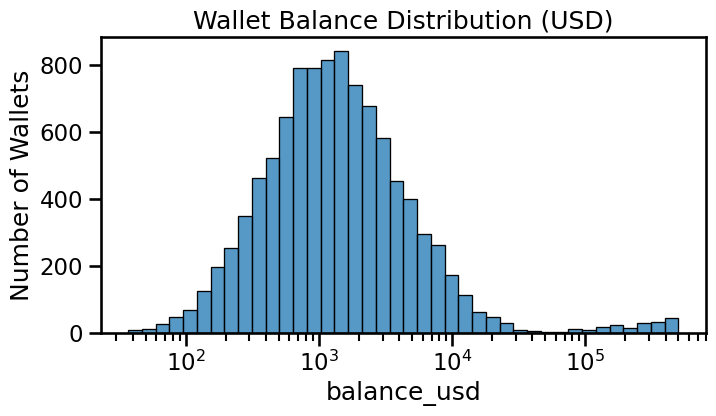

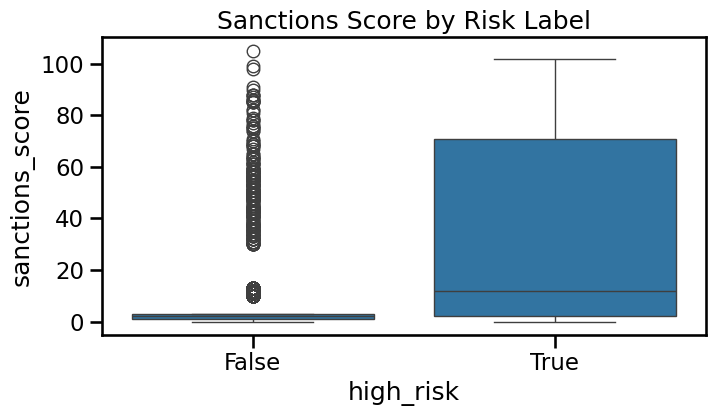

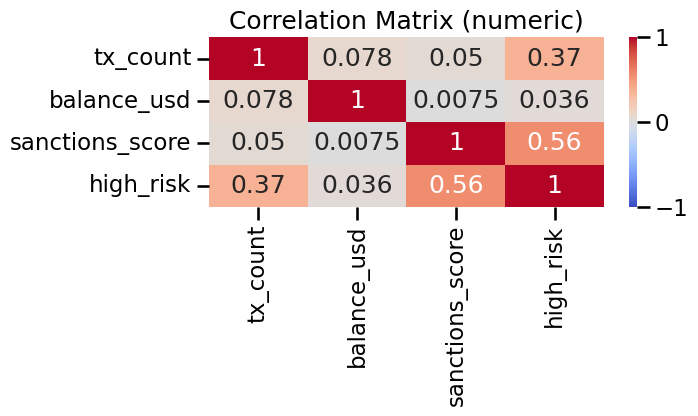

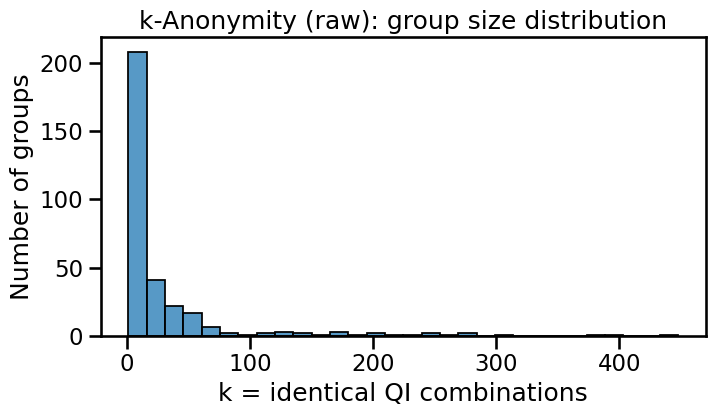

Share of groups with k < 5 (raw): 30.030959752321984 %


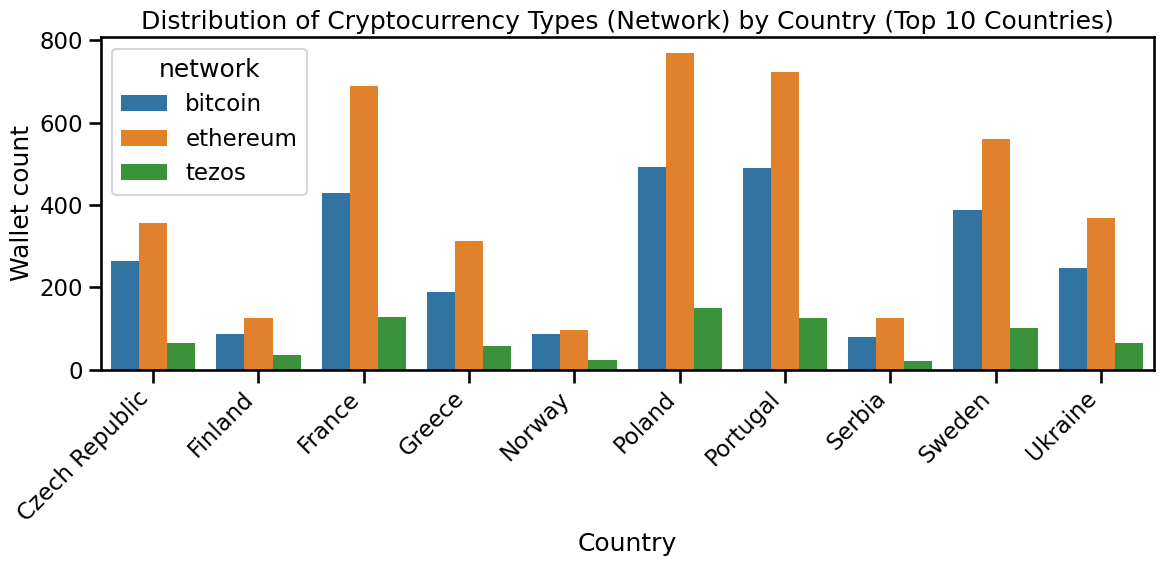

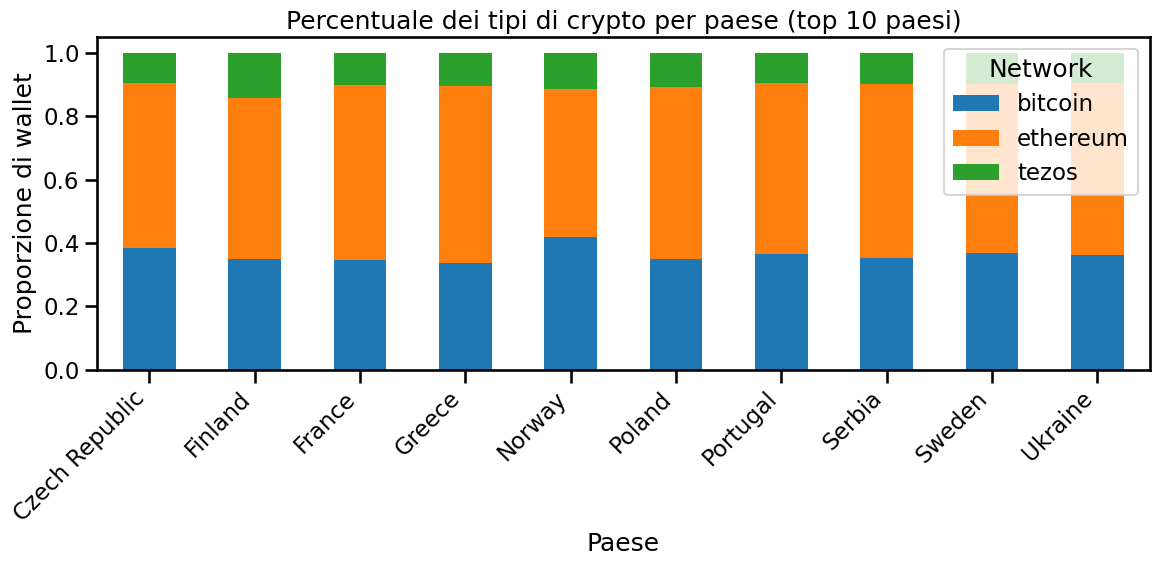

In [9]:
# Balance distribution
sns.histplot(crypto_wallet_df['balance_usd'], bins=40, log_scale=(True, False))
plt.title('Wallet Balance Distribution (USD)')
plt.xlabel('balance_usd'); plt.ylabel('Number of Wallets'); plt.tight_layout(); plt.show()

# Sanctions score vs label
sns.boxplot(x='high_risk', y='sanctions_score', data=crypto_wallet_df)
plt.title('Sanctions Score by Risk Label')
plt.xlabel('high_risk'); plt.ylabel('sanctions_score'); plt.tight_layout(); plt.show()

# Correlations (numeric)
numeric_cols = ['tx_count', 'balance_usd', 'sanctions_score', 'high_risk']
sns.heatmap(crypto_wallet_df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (numeric)'); plt.tight_layout(); plt.show()

# Baseline k-anonymity estimate on raw QIs
qi_raw = ['country','network','client_type']
group_sizes_raw = crypto_wallet_df.groupby(qi_raw).size()
sns.histplot(group_sizes_raw, bins=30)
plt.title('k-Anonymity (raw): group size distribution')
plt.xlabel('k = identical QI combinations'); plt.ylabel('Number of groups'); plt.tight_layout(); plt.show()

print("Share of groups with k < 5 (raw):",
      (group_sizes_raw < 5).mean() * 100, "%")

# Crypto distribution over countries
df_count = crypto_wallet_df.groupby(['country', 'network']).size().reset_index(name='count')

top_countries = df_count.groupby('country')['count'].sum().nlargest(10).index
df_top = df_count[df_count['country'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.barplot(data=df_top, x='country', y='count', hue='network')
plt.title('Distribution of Cryptocurrency Types (Network) by Country (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Wallet count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

pivot = df_top.pivot(index='country', columns='network', values='count').fillna(0)

pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)

pivot_pct.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Percentuale dei tipi di crypto per paese (top 10 paesi)')
plt.xlabel('Paese')
plt.ylabel('Proporzione di wallet')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Network')
plt.tight_layout()
plt.show()

# 3) Mask direct identifiers


In [5]:
df_gen = crypto_wallet_df.copy()

df_gen['address_prefix'] = df_gen['address'].str[:6] + '***'
#df_gen = df_gen.drop(columns=['address'])

df_gen.head(3)

,address,network,country,client_type,last_active,tx_count,balance_usd,mixer_usage,sanctions_score,high_risk,address_prefix
0,19MCTdu6DPM4PpEiCiHd4zkw1rj8aRuezg,bitcoin,Germany,api,03/11/2023,1098,9429.42,never,13.0,False,19MCTd***
1,tz1RjZnRPTVUmdE9rubXdBesHUcd9w9wRa5T,tezos,Portugal,desktop,12/05/2024,567,5214.24,never,0.0,False,tz1RjZ***
2,0x6cdc950a633e6a3017e912f37c0e42bc30e5a57b,ethereum,France,desktop,22/02/2024,883,5383.56,never,1.0,False,0x6cdc***


# 4) Generalize QIs

In [6]:
top_countries = df_gen['country'].value_counts().nlargest(10).index
df_gen['country_generalized'] = df_gen['country'].where(df_gen['country'].isin(top_countries), 'Other')

df_gen['client_type_generalized'] = df_gen['client_type'].replace({'api': 'non-human',
                                                                   'desktop': 'human',
                                                                   'mobile': 'human'})

df_gen = df_gen.drop(columns=['country', 'client_type'])

# 5) Generalizing balance_usd

In [7]:
# EITHER bin OR add noise (choose one)
# Set USE_BINNING = True to bin (stronger privacy, less numeric utility)
# Set USE_BINNING = False to add small noise (keeps numeric utility)

USE_BINNING = True

if USE_BINNING:
    df_gen['balance_bin'] = pd.cut(df_gen['balance_usd'],
                                   bins=[0,100,1000,10000,100000,1e9],
                                   labels=['0-100','100-1k','1k-10k','10k-100k','>100k'],
                                   include_lowest=True, right=True)
else:
    noise_factor = 0.02  # ±2% noise
    df_gen['balance_usd'] = df_gen['balance_usd'] * (
        1 + np.random.uniform(-noise_factor, noise_factor, len(df_gen))
    )

In [8]:
df_gen[['country_generalized','client_type_generalized', 'balance_bin']].head(3)

,country_generalized,client_type_generalized,balance_bin
0,Other,non-human,1k-10k
1,Portugal,human,1k-10k
2,France,human,1k-10k


# 6) Local suppression (k<5)

Suppressed records: 10/10000 (0.10%)
Unique QI groups suppressed (k < 5): 4


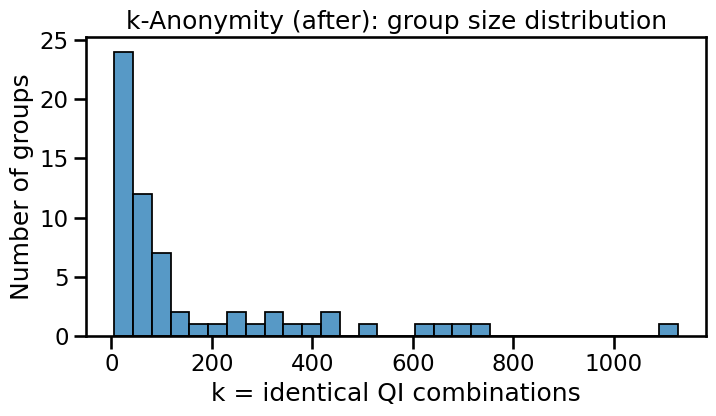

Share of groups with k < 5 (after): 0.0 %


In [15]:
qi = ['country_generalized', 'network', 'client_type_generalized']

group_counts = df_gen.groupby(qi).size().to_dict()
df_gen['k'] = df_gen[qi].apply(tuple, axis=1).map(group_counts)

for q in qi:
    df_gen.loc[df_gen['k'] < 5, q] = np.nan

suppressed_records = df_gen[qi].isna().any(axis=1).sum()
total_records = len(df_gen)
print(f"Suppressed records: {suppressed_records}/{total_records} ({suppressed_records/total_records*100:.2f}%)")

num_small_groups = sum(v < 5 for v in group_counts.values())
print(f"Unique QI groups suppressed (k < 5): {num_small_groups}")

group_sizes_after = df_gen.groupby(qi).size()
sns.histplot(group_sizes_after, bins=30)
plt.title('k-Anonymity (after): group size distribution')
plt.xlabel('k = identical QI combinations'); plt.ylabel('Number of groups'); plt.tight_layout(); plt.show()

print("Share of groups with k < 5 (after):",
      (group_sizes_after < 5).mean() * 100, "%")

# 7) Utility Evaluation: Logistic Regression (Before vs After)

In [16]:
def prepare_data(df_in):
    df = df_in.copy()
    df = df.dropna(subset=['high_risk'])

    has_gen = {'country_generalized', 'client_type_generalized'}.issubset(df.columns)
    cat_feats = []
    num_feats = []

    if has_gen:
        # AFTER anonymization
        cat_feats = ['country_generalized', 'network', 'client_type_generalized', 'mixer_usage']
        if USE_BINNING:
            cat_feats += ['balance_bin']     # binned balance as categorical
            num_feats = ['tx_count', 'sanctions_score']
        else:
            num_feats = ['tx_count', 'sanctions_score', 'balance_usd']  # numeric with small noise
    else:
        # BEFORE anonymization
        cat_feats = ['country', 'network', 'client_type', 'mixer_usage']
        num_feats = ['tx_count', 'sanctions_score', 'balance_usd']

    X = df[cat_feats + num_feats]
    y = df['high_risk'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
    )
    return X_train, X_test, y_train, y_test, cat_feats, num_feats


def make_pipeline(cat_cols, num_cols):
    pre = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])
    model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE)
    return Pipeline(steps=[('prep', pre), ('model', model)])


def evaluate_logreg(df, label):
    X_train, X_test, y_train, y_test, cat_cols, num_cols = prepare_data(df)
    pipe = make_pipeline(cat_cols, num_cols)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    print(f"\n--- {label} ---")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f} | F1: {f1:.3f}")
    return {'Accuracy': acc, 'ROC-AUC': auc, 'F1': f1}


metrics_before = evaluate_logreg(crypto_wallet_df, "Before Anonymization")
metrics_after  = evaluate_logreg(df_gen,            "After Anonymization")


--- Before Anonymization ---
Accuracy: 0.949 | ROC-AUC: 0.836 | F1: 0.704

--- After Anonymization ---
Accuracy: 0.949 | ROC-AUC: 0.864 | F1: 0.707


# 8) Save anonymized microdata

In [ ]:
OUT_PATH = '/content/drive/MyDrive/MICAC/PPIA/Crypto_anonymized.csv'
df_gen.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)